###**XOR Problem**

In [ ]:
import torch
import torch.nn as nn

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)

if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [ ]:
# 0은 거짓 1은 참 이라고 생각하자.

X = torch.FloatTensor([[0, 0], [0, 1], [1, 0], [1, 1]]).to(device)
Y = torch.FloatTensor([[0], [1], [1], [0]]).to(device)

class XOR_gate(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
                    nn.Linear(2, 10, bias=True),
                    nn.Sigmoid(),
                    nn.Linear(10, 10, bias=True),
                    nn.Sigmoid(),
                    nn.Linear(10, 10, bias=True),
                    nn.Sigmoid(),
                    nn.Linear(10, 1, bias=True),
                    nn.Sigmoid()
    )

  def forward(self, x):
    return self.linear(x)


model = XOR_gate()
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1)

def train():
  model.train()

  for step in range(10001):
    optimizer.zero_grad()
    pred = model(X)

    loss = criterion(pred, Y)
    loss.backward()
    optimizer.step()


if __name__ == '__main__':
  train()
  
  hypothesis = model(X)
  predicted = (hypothesis > 0.5).float()

  print('모델의 출력값: ', hypothesis)
  print('모델의 예측값: ', predicted)
  print('실제값: ', Y)

0.00010565484262770042
모델의 출력값:  tensor([[9.4587e-05],
        [9.9989e-01],
        [9.9990e-01],
        [1.1471e-04]], grad_fn=<SigmoidBackward0>)
모델의 예측값:  tensor([[0.],
        [1.],
        [1.],
        [0.]])
실제값:  tensor([[0.],
        [1.],
        [1.],
        [0.]])


###**다층 퍼셉트론으로 sklearn 손글씨 분류하기**

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from torch import cuda

training_epochs = 100
device = 'cuda' if cuda.is_available() else 'cpu'
print(f'Training sklearn Model on {device}\n{"="*44}')

digits = load_digits()

Training sklearn Model on cpu


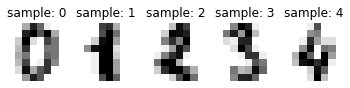

In [ ]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:5]): # 5개의 샘플만 출력
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('sample: %i' % label)

In [ ]:
# digits.images 는 8x8 행렬로 저장하지만 digits.data는 64차원의 행렬로 저장됩니다.
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [ ]:
import torch
import torch.nn as nn

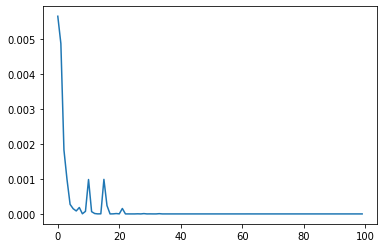

In [ ]:
# dataset

X = torch.tensor(digits.data, dtype=torch.float32)
Y = torch.tensor(digits.target, dtype=torch.int64)

# class

class digits_classification(nn.Module):
  def __init__(self):
    super().__init__()
    self.clf = nn.Sequential(
                  nn.Linear(64, 32),
                  nn.ReLU(),
                  nn.Linear(32, 16),
                  nn.ReLU(),
                  nn.Linear(16, 10)
    )
  def forward(self, x):
    return self.clf(x)

# model

model = digits_classification()
model.to(device)

# Training Setup

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training Function

def train():
  model.train()

  for data, target in list(zip(X, Y)):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
  
  return loss.item()

if __name__ == '__main__':
  losses = []

  for epoch in range(training_epochs):
    losses.append(train())

  plt.plot(losses)


###**다층 퍼셉트론으로 MNIST 분류하기**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_openml

In [ ]:
# dataset

mnist = fetch_openml('mnist_784', version=1, cache=True)   # mnist.data, mnist.target

In [ ]:
# data

X = mnist.data / 255          # 총 70000개의 data이고 각각의 shape은 (784, )이다.
Y = mnist.target.astype(np.int8)    # target은 처음에는 문자열로 나온다.

print(X.shape)

(70000, 784)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다: ", device)

다음 기기로 학습합니다:  cpu


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1/7, random_state=0)

X_train = torch.Tensor(X_train.values)     # 여기서 .values를 안 쓰면 pandas dataframe 형태여서 안 먹힘
X_test = torch.Tensor(X_test.values)
Y_train = torch.LongTensor(Y_train.values)
Y_test = torch.LongTensor(Y_test.values)

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=64, 
                          shuffle=True
                          )

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=64,
                         shuffle=False
                         )

class MNIST_Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Sequential(
                    nn.Linear(28*28, 100),
                    nn.ReLU(),
                    nn.Linear(100, 100),
                    nn.ReLU(),
                    nn.Linear(100, 10)
    )

  def forward(self, x):
    return self.linear(x)


model = MNIST_Net()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(epoch):
    model.train()

    for data, targets in train_loader:

        optimizer.zero_grad()  
        outputs = model(data)  
        loss = criterion(outputs, targets)  
        loss.backward()  
        optimizer.step()  

    print("epoch {}：완료\n".format(epoch))


def test():
    model.eval()  
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data) 

            predicted = output.data.max(1, keepdim=True)[1] 
            correct += predicted.eq(target.data.view_as(predicted)).sum()  # 정답과 일치한 경우 정답 카운트를 증가

    # 정확도 출력
    data_num = len(test_loader.dataset)  # 데이터 총 건수
    print('\n테스트 데이터에서 예측 정확도: {}/{} ({:.0f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num))
    

if __name__ == '__main__':
  for epoch in range(3):
    train(epoch)

  test()

epoch 0：완료

epoch 1：완료

epoch 2：완료


테스트 데이터에서 예측 정확도: 9612/10000 (96%)

